In [7]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import numpy as np
import missingno

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, fbeta_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from category_encoders import BinaryEncoder

import featuretools as ft
from featuretools.primitives import make_trans_primitive
from featuretools.variable_types import Numeric

import tensorflow
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Input, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.regularizers import L1L2

In [43]:
timestep = 8 #from 1 to 23 (17 with the current NaN strategy)
threshold_for_classification = -6.0
fill_X = -0.01
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
seed = 11
features = ['event_id','time_to_tca', 'risk', 'c_time_lastob_end', 
             'c_time_lastob_start', 'max_risk_estimate',
             'max_risk_scaling', "event_length",
             "high_risk_count", "mean_tca_jump",
             "mean_risk_jump", "positive_risk_jump"]

#RNN hiperparameter
epochs = 1
batch = 256
val_split = 0.25
test_split = 0.25
adam = optimizers.Adam(lr=0.001) #(lr)
class_weight = {True:  50.,
                False: 1.}
verbose = 1

In [44]:
# Help functions

def feature_tools(df):
    
    # Make an entityset and add the entity
    es = ft.EntitySet(id = 'events')
    es.entity_from_dataframe(entity_id = 'data', dataframe = df, 
                             make_index = True, index = 'index')
    
    #Trans Primitives
    def Log(column):
        return np.log(column)
    def Square_Root(column):
        return np.sqrt(column)
    def Power_2(column):
        return np.power(column, 2)
    
    # Create the primitives
    log_prim = make_trans_primitive(function=Log,
                                    input_types=[Numeric],
                                    return_type=Numeric)
    square_root_prim = make_trans_primitive(function=Square_Root,
                                            input_types=[Numeric],
                                            return_type=Numeric)
    power_2_prim = make_trans_primitive(function=Power_2,
                                            input_types=[Numeric],
                                            return_type=Numeric)
    
    # Run deep feature synthesis with transformation primitives
    feature_matrix, feature_defs = ft.dfs(entityset = es,
                                          target_entity = 'data',
                                          trans_primitives = ['add_numeric',
                                                              'multiply_numeric',
                                                              'subtract_numeric',
                                                              'divide_numeric',
                                                              'modulo_numeric',
                                                              log_prim,
                                                              square_root_prim,
                                                              power_2_prim,
                                                             ],
                                          max_features=2000,
                                          n_jobs=-1)

    return feature_matrix, feature_defs

In [45]:
#Importing data
df = pd.read_csv("train_data.csv")

#Dropping first the empty column and then rows with NaNs
df = df.drop("c_rcs_estimate", axis=1)
df = df.dropna(how='any')

#Filtering events with len=1 or min_tca > 2 or max_tca < 2
def conditions(event):
    x = event["time_to_tca"].values
    return ((x.min()<2.0) & (x.max()>2.0))
df = df.groupby('event_id').filter(conditions)

#OHE for c_object_type (5 categories) -> 5 new features
df["mission_id"] = df["mission_id"].astype('category')
df["c_object_type"] = df["c_object_type"].astype('category')
df = pd.get_dummies(df)

#Getting y as 1D-array
y = df.groupby(["event_id"])["risk"].apply(lambda x: x.iloc[-1]).values.reshape(-1, 1)

#Scaling y
_ = y_scaler.fit(df["risk"].values.reshape(-1, 1)) #using the whole risk feature to scale the target 'y'
y = y_scaler.transform(y)

#Getting X as df (dropping rows with tca < 2) 
df = df.loc[df["time_to_tca"]>2]


### Feature Engineering ###


#Adding feature 'event_length' for counting how many instances each event has
df["event_length"] = df.groupby('event_id')['event_id'].transform('value_counts')

#Adding feature 'high_risk_count' for counting how many high risk instances each event has
df["high_risk_count"] = df.groupby('event_id')['risk'].transform(lambda x: (x > -6.0).sum())

#Adding feature 'mean_tca_jump' for computing mean tca jump each event has
df["mean_tca_jump"] = df.groupby('event_id')['time_to_tca'].transform(lambda x: x.diff().mean())

#Adding feature 'mean_risk_jump' for computing mean risk jump each event has
df["mean_risk_jump"] = df.groupby('event_id')['risk'].transform(lambda x: x.diff().mean())

#Adding feature 'positive_risk_jump' for computing positive risk jumps each event has (from high to low)
df["positive_risk_jump"] = df.groupby('event_id')['risk'].transform(lambda x: (x.diff() > 0.0).sum())

#Adding feature 'negative_risk_jump' for computing positive risk jumps each event has (from low to high)
df["negative_risk_jump"] = df.groupby('event_id')['risk'].transform(lambda x: (x.diff() < 0.0).sum())

#Fill NaNs 
values = {'mean_tca_jump': 0, 'mean_risk_jump': 0}
df.fillna(value=values, inplace=True)

# Brute force feature engineering
df = df[features]
df, _ = feature_tools(df)

# Removing columns with missing and infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(axis=1, how="any", inplace=True)

# Removing invariant columns
df = df.loc[:, (df != df.iloc[0]).any()] 

display(df)


### Transforming df into a 3D-array ###


#Scaling X
df = pd.DataFrame(X_scaler.fit_transform(df), columns=df.columns)

events = df["event_id"].nunique() #rows
features = len(df.columns) #columns

X = np.zeros((events,timestep,features))
X.fill(fill_X)

i = 0
def df_to_3darray(event):
    global X, i
    #Transforming an event to time series (1,timesteps, columns)
    row = event.values.reshape(1,event.shape[0],event.shape[1])
    #Condition is needed to slice arrays correctly
    #Condition -> is timestep greater than the event's time series length? 
    if(timestep>=row.shape[1]):
        X[i:i+1,-row.shape[1]:,:] = row
    else:
        X[i:i+1,:,:] = row[:,-timestep:,:]
    #index to iterate over X array
    i = i + 1
    #dataframe remains intact, while X array has been filled.
    return event

df.groupby("event_id").apply(df_to_3darray)

#Dropping event_id to remove noise
X = X[:,:,1:]

#TODO: Padding with specific values column-wise instead of zeros.
#TODO: Separating time dependent and independent feature in 2 X arrays

print(X.shape, y.shape)

EntitySet scattered to 12 workers in 3 seconds


event_id  time_to_tca       risk  c_time_lastob_end  \
index                                                        
0             2     6.983474 -10.816161                2.0   
1             2     6.691611 -10.850473                2.0   
2             2     6.269979 -30.000000                0.0   
3             2     6.042352 -30.000000                0.0   
4             2     5.711716 -30.000000                0.0   
...         ...          ...        ...                ...   
85728     13153     3.408859  -7.080451                2.0   
85729     13153     3.029751  -7.108630                2.0   
85730     13153     2.799253  -7.070070                2.0   
85731     13153     2.385399  -7.066209                2.0   
85732     13153     2.043339  -7.028307                2.0   

       c_time_lastob_start  max_risk_estimate  max_risk_scaling  event_length  \
index                                                                           
0                    180.0          -6.601713         13.293159            14   
1                    180.0          -6.603452         13.374242            14   
2                      1.0          -6.217958        426.808532            14   
3                      1.0          -6.271078        181.496778            14   
4                      1.0          -6.277448        187.525360            14   
...                    ...                ...               ...           ...   
85728                180.0          -5.140501          7.492353            12   
85729                180.0          -5.142668          7.561579            12   
85730                180.0          -5.137869          7.471857            12   
85731                180.0          -5.137034          7.463470            12   
85732                180.0          -5.131297          7.378397            12   

       high_risk_count  mean_tca_jump  mean_risk_jump  positive_risk_jump  \
index                                                                       
0                  0.0      -0.357142       -1.475680                 0.0   
1                  0.0      -0.357142       -1.475680                 0.0   
2                  0.0      -0.357142       -1.475680                 0.0   
3                  0.0      -0.357142       -1.475680                 0.0   
4                  0.0      -0.357142       -1.475680                 0.0   
...                ...            ...             ...                 ...   
85728              0.0      -0.437633        0.003148                 6.0   
85729              0.0      -0.437633        0.003148                 6.0   
85730              0.0      -0.437633        0.003148                 6.0   
85731              0.0      -0.437633        0.003148                 6.0   
85732              0.0      -0.437633        0.003148                 6.0   

       event_length + high_risk_count  event_length + time_to_tca  \
index                                                               
0                                14.0                   20.983474   
1                                14.0                   20.691611   
2                                14.0                   20.269979   
3                                14.0                   20.042352   
4                                14.0                   19.711716   
...                               ...                         ...   
85728                            12.0                   15.408859   
85729                            12.0                   15.029751   
85730                            12.0                   14.799253   
85731                            12.0                   14.385399   
85732                            12.0                   14.043339   

       mean_risk_jump + risk  c_time_lastob_start + max_risk_estimate  \
index                                                                   
0                 -12.291841                               173.398287   
1                 -12.32615

(7311, 8, 1878) (7311, 1)


In [46]:
#computing scaled threshold 
th = np.array([threshold_for_classification]).reshape(-1,1)
th = y_scaler.transform(th)
threshold_scaled = th[0,0]

#Splitting arrays
y_boolean = (y > threshold_scaled).reshape(-1,1)
X_train, X_test, y_train_numeric, y_test_numeric = train_test_split(X, y, 
                                                    stratify=y_boolean, 
                                                    shuffle=True,
                                                    random_state=seed,
                                                    test_size = test_split
                                                  )

y_train_boolean = (y_train_numeric > threshold_scaled).reshape(-1,1)
X_train, X_val, y_train_numeric, y_val_numeric = train_test_split(X_train, y_train_numeric, 
                                                    stratify=y_train_boolean, 
                                                    shuffle=True,
                                                    random_state=seed,
                                                    test_size = val_split
                                                  )
#transforming it into a classification task -> y_train, y_test boolean
y_train = (y_train_numeric > threshold_scaled).reshape(-1,1)
y_val = (y_val_numeric > threshold_scaled).reshape(-1,1)
y_test = (y_test_numeric > threshold_scaled).reshape(-1,1)

#Percentage of high risks in train
print("TRAIN {:0.1f}, {:0.1f}, {:0.3f}".format(np.sum(y_train), y_train.shape[0], np.sum(y_train)/y_train.shape[0]))
#Percentage of high risks in val
print("VAL   {:0.1f}, {:0.1f}, {:0.3f}".format(np.sum(y_val), y_val.shape[0], np.sum(y_val)/y_val.shape[0]))
#Percentage of high risks in test
print("TEST  {:0.1f}, {:0.1f}, {:0.3f}".format(np.sum(y_test), y_test.shape[0], np.sum(y_test)/y_test.shape[0]))

TRAIN 41.0, 4112.0, 0.010
VAL   14.0, 1371.0, 0.010
TEST  18.0, 1828.0, 0.010


In [47]:
# Model activation selu
input_tensor = Input(batch_shape=(batch, timestep, X_train.shape[2]))
rnn_1 = LSTM(50, stateful=False, dropout=0.15, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=L1L2(l1=0.0, l2=0.01))(input_tensor)
batch_1 = BatchNormalization()(rnn_1)
rnn_2 = LSTM(25, stateful=False, dropout=0.15, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=L1L2(l1=0.0, l2=0.01))(batch_1)
batch_2 = BatchNormalization()(rnn_2)
rnn_3 = LSTM(12, stateful=False, dropout=0.15, recurrent_dropout=0.3, return_sequences=False, kernel_regularizer=L1L2(l1=0.0, l2=0.01))(batch_2)
batch_3 = BatchNormalization()(rnn_3)
output_tensor = Dense(units = 1, activation='sigmoid')(batch_3)


model = Model(inputs=input_tensor,
              outputs= output_tensor)

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(256, 8, 1878)]          0         
_________________________________________________________________
lstm_9 (LSTM)                (256, 8, 50)              385800    
_________________________________________________________________
batch_normalization_9 (Batch (256, 8, 50)              200       
_________________________________________________________________
lstm_10 (LSTM)               (256, 8, 25)              7600      
_________________________________________________________________
batch_normalization_10 (Batc (256, 8, 25)              100       
_________________________________________________________________
lstm_11 (LSTM)               (256, 12)                 1824      
_________________________________________________________________
batch_normalization_11 (Batc (256, 12)                 48  

In [48]:
model_history = model.fit(X_train, y_train, 
                          epochs=epochs, 
                          batch_size=batch, 
                          #shuffle=True, #OJO
                          validation_data=(X_val, y_val),
                          verbose=verbose,
                          class_weight=class_weight
                         ).history

Train on 4112 samples, validate on 1371 samples
4112/4112 [==============================] - 5s 1ms/sample - loss: 5.5015 - accuracy: 0.5423 - val_loss: 5.0656 - val_accuracy: 0.9220


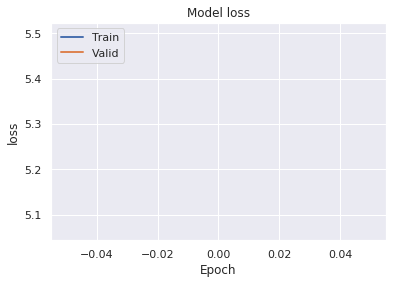

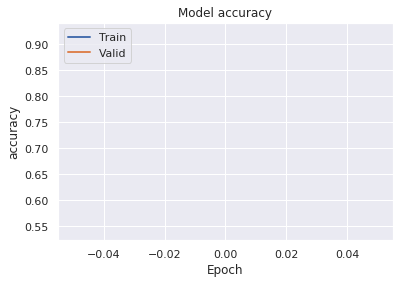

In [49]:
sns.set()

for graph in ['loss', 'accuracy']:
    
    plt.plot(model_history[graph], linewidth=2, label='Train')
    plt.plot(model_history['val_'+graph], linewidth=2, label='Valid')
    
    plt.legend(loc='upper left'), plt.title('Model '+graph)
    plt.ylabel(graph), plt.xlabel('Epoch')
    plt.show()

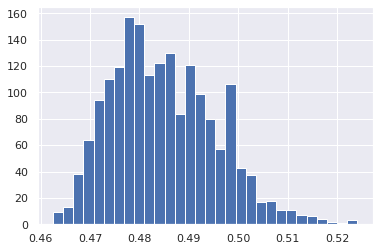

LSTM model: 3.058, 0.376, 0.123


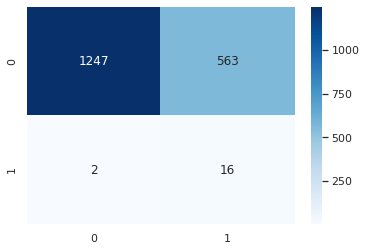

Constant prediction: 6.638, 0.314, 0.047


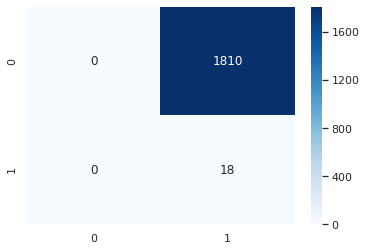

Predicting last value: 0.693, 0.367, 0.530


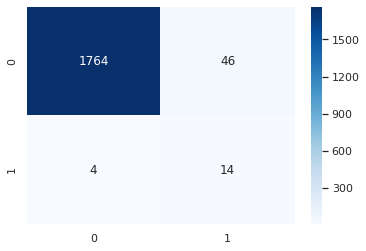

In [57]:
#Model Evaluation
high_risk_real_value = -5.0
low_risk_real_value  = -6.0001
classification_threshold = 0.49

def evaluate(name, y_pred):
    
    #rescaling data
    y_test_scaled = y_scaler.inverse_transform(y_test_numeric)
    
    #getting numeric predictions from boolean predictions
    y_pred_numeric = np.zeros((y_pred.shape[0],y_pred.shape[1]))
    y_pred_numeric[y_pred==True] = high_risk_real_value
    y_pred_numeric[y_pred==False] = low_risk_real_value
    
    #getting predictions greater than -6.0 in real data (y_test_scaled)
    y_pred_mse = y_pred_numeric[np.where(y_test_scaled >= -6.0)]
    y_test_mse = y_test_scaled[np.where(y_test_scaled >= -6.0)]
    
    mse = mean_squared_error(y_test_mse, y_pred_mse)
    
    y_real_bool = (y_test_scaled >= -6.0).reshape(-1,1)
    
    f_beta = fbeta_score(y_real_bool, y_pred, 2)
    score = mse / f_beta
    print(name, "{:0.3f}, {:0.3f}, {:0.3f}".format(score, mse, f_beta))
        
    hm = sns.heatmap(confusion_matrix(y_real_bool, y_pred), annot=True, cmap="Blues", fmt='d')
    bottom, top = hm.get_ylim()
    hm.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

#Predicting with model
y_model = model.predict(X_test, batch_size=batch)
plt.hist(y_model, bins=30)
plt.show()
y_model = (y_model > classification_threshold).reshape(-1,1)
evaluate("LSTM model:", y_model)

#Predicting -5 always
y_constant = np.ones((y_test.shape[0],y_test.shape[1]), dtype=bool)
evaluate("Constant prediction:", y_constant)

#Predicting last value
y_last = X_test[:,-1,1]
tmp = np.array([-6]).reshape(-1,1)
tmp = y_scaler.transform(tmp)
tmp = tmp[0,0]
y_last = (y_last > tmp).reshape(-1,1)
evaluate("Predicting last value:", y_last)

Predicting last value: 10.169, 5.393, 0.530


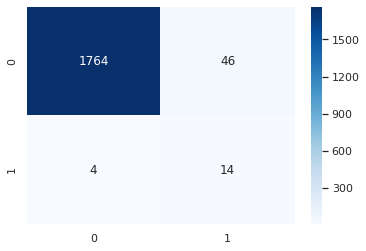

In [51]:
#Predicting last value
def recurrent_evaluate(name, y_pred):
    
    #Scaling both real predicted
    y_pred_scaled = y_scaler.inverse_transform(y_pred)
    y_real_scaled = y_scaler.inverse_transform(y_test_numeric)
    
    #boolean data
    y_pred_bool = (y_pred_scaled >= -6.0).reshape(-1,1)
    y_real_bool = (y_real_scaled >= -6.0).reshape(-1,1)
    f_beta = fbeta_score(y_real_bool, y_pred_bool, 2)
    
    #getting predictions greater than -6.0 in real data (y_real_scaled)
    y_pred_mse = y_pred_scaled[np.where(y_real_scaled >= -6.0)]
    y_real_mse = y_real_scaled[np.where(y_real_scaled >= -6.0)]
    mse = mean_squared_error(y_real_mse, y_pred_mse)
    
    #F-beta score
    score = mse / f_beta
    print(name, "{:0.3f}, {:0.3f}, {:0.3f}".format(score, mse, f_beta))
        
    #Confusion matrix
    hm = sns.heatmap(confusion_matrix(y_real_bool, y_pred_bool), annot=True, cmap="Blues", fmt='d')# font size
    bottom, top = hm.get_ylim()
    hm.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

    
y_last = X_test[:,-1,1].reshape(-1,1)
y_bool_2 = recurrent_evaluate("Predicting last value:", y_last)